## Convolutional NetWork in Pytorch

## Installs:

In [ ]:
# %pip install torch
# %pip install sklearning

## Imports

In [ ]:
# Pytorch
import torch # Pytorch
from torch import nn # Pytorch Network
from torchvision import datasets # Dataset torchvision
from torchvision import models # Models pre-trained in Pytorch
from torchvision import transforms # Transforms Data in tensors
from torch.utils.data import DataLoader # DataLoader Pytorch
from torch import optim # Optimizer

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Sklearn
from sklearn.metrics import accuracy_score # Metrics classification

# Time
import time

## Configs:

In [ ]:
# Pytorch
#torch.cuda.empty_cache()

## Parameters and Hyperparameters

In [ ]:
args = {
    'device': '',
    'batch_size': 20,
    'num_workers': 2,
    'lr': 1e-3,
    'weight_decay': 5e-4,
    'num_epochs': 3
}

In [ ]:
if torch.cuda.is_available():
    args['device'] = 'cuda'
else:
    args['device'] = 'cpu'

print(args['device'])

cuda


## Pre-trained network

## Imagenet

In [ ]:

# Transforming the data according to the training of the pre-trained network
data_transform = transforms.Compose([
    transforms.Resize(244),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

## Loading data

In [ ]:
# Train set
train_set = datasets.CIFAR10(
    '.',
    train = True,
    transform = data_transform,
    download = True
)

Files already downloaded and verified


In [ ]:
# Validation set
validation_set = datasets.CIFAR10(
    '.',
    train = False,
    transform = data_transform,
    download = False
)

## Viewing data

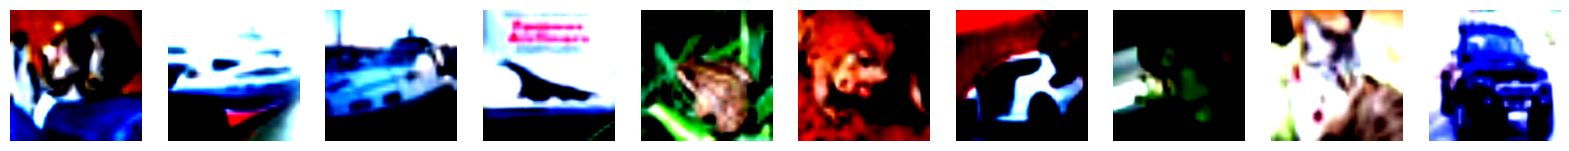

In [ ]:
fig, axs = plt.subplots(1, 10, figsize = (20, 2))
for i in range(10):
    data, label  = validation_set[i]
    axs[i].imshow(data.permute((1, 2, 0)))
    axs[i].axis('off')

## DataLoader

In [ ]:
# Train Loader
train_loader = DataLoader(
    dataset = train_set,
    batch_size = args['batch_size'],
    num_workers = args['num_workers'],
    shuffle = True
)

In [ ]:
# Validation_loader
validation_loader = DataLoader(
    dataset = validation_set,
    batch_size = args['batch_size'],
    num_workers = args['num_workers'],
    shuffle = True
)

In [ ]:
# Visualizing train_loader data
for batch in train_loader:
    data, label = batch
    print(data.size(), label.size())
    break

torch.Size([20, 3, 244, 244]) torch.Size([20])


## Adapting network - VGG16

## Fine Tuning

In [ ]:
# Downloading a pre-trained model
net = models.vgg16_bn(pretrained = True)

In [ ]:
input = list(net.children())[-1][-1].in_features
print(input)

4096


In [ ]:
new_classifier = list(net.classifier.children())[:-1]
new_classifier.append(nn.Linear(input, 10))

In [ ]:
net.classifier = nn.Sequential(*new_classifier)
net = net.to(args['device'])
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Optimizer

In [ ]:
optimizer = optim.Adam([
            {'params': net.features.parameters(), 'lr':args['lr'] * 0.2, 'weight_decay': args['weight_decay'] * 0.2},
            {'params': net.classifier.parameters(), 'lr': args['lr'], 'weight_decay': args['weight_decay']}
        ], lr=0)

## Loss

In [ ]:
criterion = nn.CrossEntropyLoss().to(args['device'])

## Training Flow

In [1]:
def train(train_loader, net, epoch):

    # Training mode
    net.train()

    # Start Epochs
    start = time.time()

    # List epochs loss and accuracy
    epoch_loss = []
    pred_list, label_list = [], []

    # Batchs for epochs
    for k, batch in enumerate(train_loader):

        print(f'\r--{k}/{len(train_loader)}--', end = '', flush = True)

        # Separating data from labels
        data, label = batch

        # Cast data in Device
        data = data.to(args['device'])
        label = label.to(args['device'])

        # Forward
        ypred = net(data)
        loss = criterion(ypred, label)

        # Metrics
        epoch_loss.append(loss.cpu().data)
        _, pred = torch.max(ypred, axis = 1)
        pred_list.append(pred.cpu().numpy())
        label_list.append(label.cpu().numpy())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Salving Metrics List
    epoch_loss = np.asarray(epoch_loss)
    pred_list = np.asarray(pred_list).ravel()
    label_list = np.asarray(label_list).ravel()

    # Accuracy
    acc = accuracy_score(pred_list, label_list)

    # Final epoch
    end = time.time()

    # Output info train
    print('\n#################### Train ####################')
    print(f'Epoch {epoch} Loss {epoch_loss.mean():.4f} +/- {epoch_loss.std():.4f} -- Acuuracy {acc * 100:.2f} Time {end - start:.2f}')

    # Returning
    return epoch_loss.mean()

## Validation Flow

In [ ]:
def validation(validation_loader, net, epoch):

    # Evaluation mode
    net.eval()

    # Start Epochs
    start = time.time()

    # List epochs loss and accuracy
    epoch_loss = []
    pred_list, label_list = [], []

    # Disabling network weights
    with torch.no_grad():
        for k, batch in enumerate(validation_loader):
            print(f'\r--{k}/{len(validation_loader)}--', end = '', flush = True)

            # Separating data from labels
            data, label = batch

            # Cast data in Device
            data = data.to(args['device'])
            label = label.to(args['device'])

            # Forward
            ypred = net(data)
            loss = criterion(ypred, label)

            # Metrics
            epoch_loss.append(loss.cpu().data)
            _, pred = torch.max(ypred, axis = 1)
            pred_list.append(pred.cpu().numpy())
            label_list.append(label.cpu().numpy())

    # Salving Metrics List
    epoch_loss = np.asarray(epoch_loss)
    pred_list = np.asarray(pred_list).ravel()
    label_list = np.asarray(label_list).ravel()

    # Accuracy
    acc = accuracy_score(pred_list, label_list)

    # Final epoch
    end = time.time()

    # Output info train
    print('\n********** Validate **********')
    print(f'Epoch {epoch} Loss {epoch_loss.mean():.4f} +/- {epoch_loss.std():.4f} -- Acuuracy {acc * 100:.2f} Time {end - start:.2f}')

    # Returning
    return epoch_loss.mean()

# Training

In [ ]:
# Training
train_loss, validation_loss = [], []

for epoch in range(args['num_epochs']):

    # Train
    train_loss.append(train(train_loader, net, epoch))

    # Validation
    validation_loss.append(validation(validation_loader, net, epoch))


--2499/2500--
#################### Train ####################
Epoch 0 Loss 0.7784 +/- 0.3698 -- Acuuracy 74.91 Time 1352.34


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--499/500--

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



********** Validate **********
Epoch 0 Loss 0.5816 +/- 0.2673 -- Acuuracy 81.63 Time 93.75


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--2499/2500--

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



#################### Train ####################
Epoch 1 Loss 0.5016 +/- 0.2569 -- Acuuracy 84.41 Time 1351.70


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--499/500--

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



********** Validate **********
Epoch 1 Loss 0.5701 +/- 0.3030 -- Acuuracy 83.89 Time 93.61


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--2499/2500--

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



#################### Train ####################
Epoch 2 Loss 0.4101 +/- 0.2336 -- Acuuracy 87.49 Time 1350.60


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--499/500--

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



********** Validate **********
Epoch 2 Loss 0.3978 +/- 0.2295 -- Acuuracy 87.78 Time 94.67


## Viewing training and testing

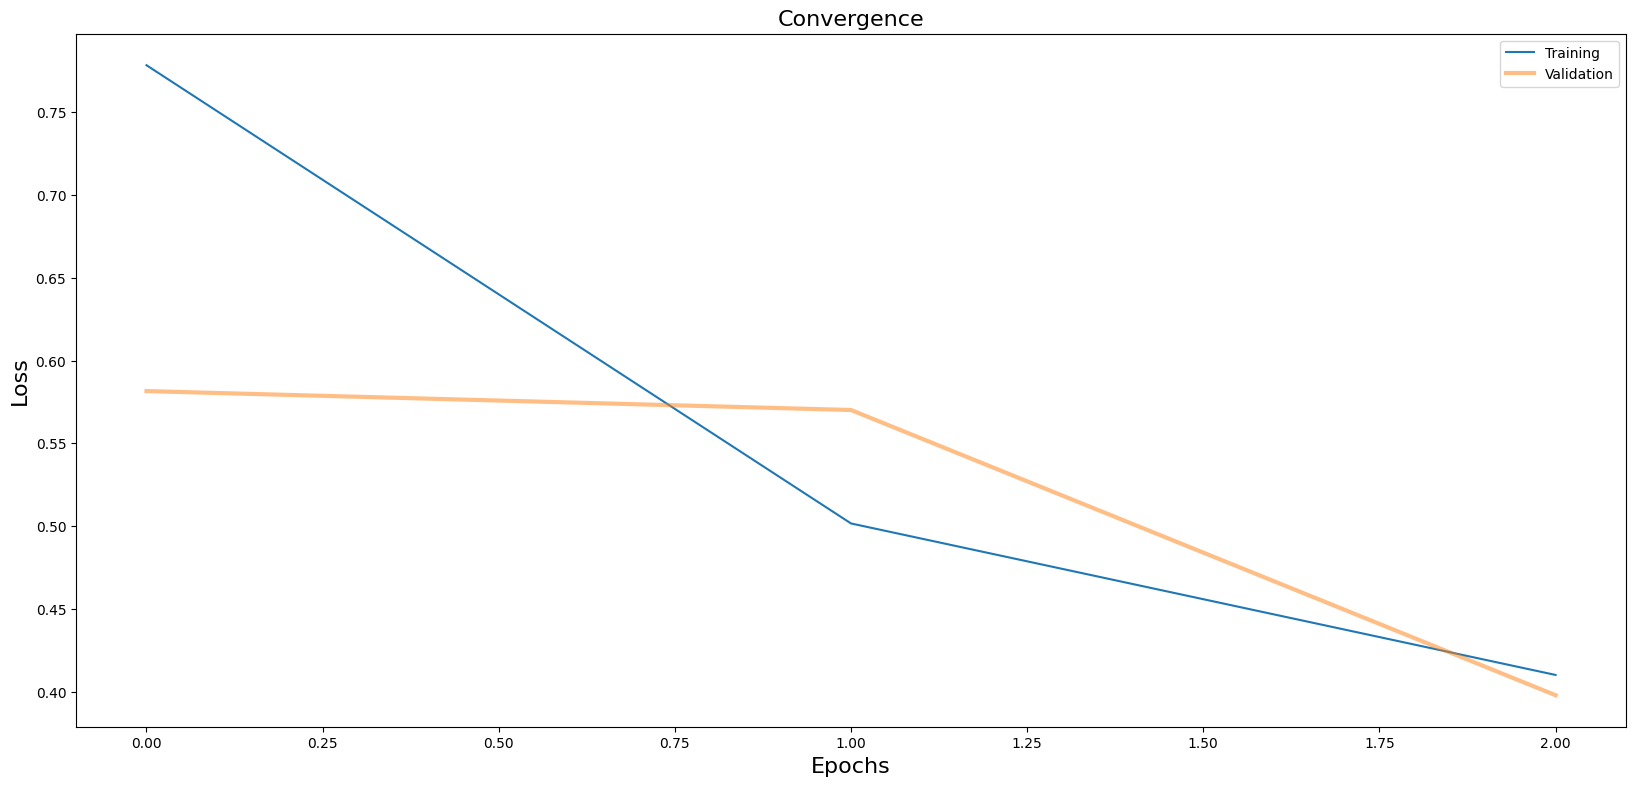

In [ ]:
plt.figure(figsize = (20, 9))
plt.plot(train_loss, label = 'Training')
plt.plot(validation_loss, label = 'Validation', linewidth = 3, alpha = 0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()